In [1]:
%run ../scripts/notebook_settings.py
import sgkit as sg
import xarray as xr
import glob

In [2]:
metadata_dir = "/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/"
metadata_dirs = glob.glob(metadata_dir+"*_individuals.txt")
metadata_dirs

['/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/Carlito_individuals.txt',
 '/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/Lophocebus_individuals.txt',
 '/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/Hoolock_individuals.txt',
 '/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/Galago_individuals.txt',
 '/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/Saguinus_individuals.txt',
 '/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/Papio_individuals.txt',
 '/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/Nomascus_individuals.txt',
 '/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/Chlorocebus_individuals.txt',
 '/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/Cercopithecus_individuals.txt',
 '/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/Pygathrix_individuals.txt',
 '/hom

Reading in mutation/generation time estimates from Kuderna. I will assume that chromosome X has 80 % of the mutation rate of autosomes, corresponding to a 4:1 male bias in mutations.

In [3]:
# Mutation rate percentage calc.
(3*1/3+1*2/3)/(3*1/2+1*1/2)

# Even if females have no mutations, it's only 2/3
# (4*1/3+0*2/3)/(4*1/2+0*1/2)

0.8333333333333333

In [4]:
0.75*0.8333333333333333

0.625

In [5]:
kuderna_data = pd.read_csv("../data/science.abn7829_data_s2.csv")

In [6]:
# I pick out the following columns
col_species_mut = ['SPECIES_BINOMIAL', 'GENUS', 'SPECIES', 'FAMILY', 'GENERATION_LENGTH', 'MU_PER_GENERATION',
       'MU_PER_YEAR', 'EFFECTIVE_POP_SIZE']
df_species_mut = kuderna_data[col_species_mut]

<Axes: xlabel='MU_PER_YEAR', ylabel='Count'>

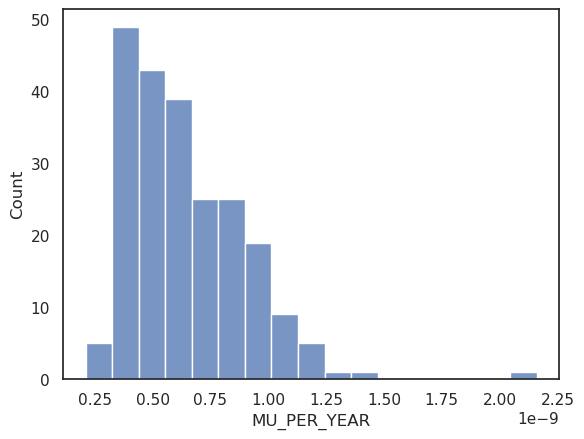

In [7]:
sns.histplot(kuderna_data[col_species_mut].MU_PER_YEAR)

<Axes: xlabel='GENERATION_LENGTH', ylabel='Count'>

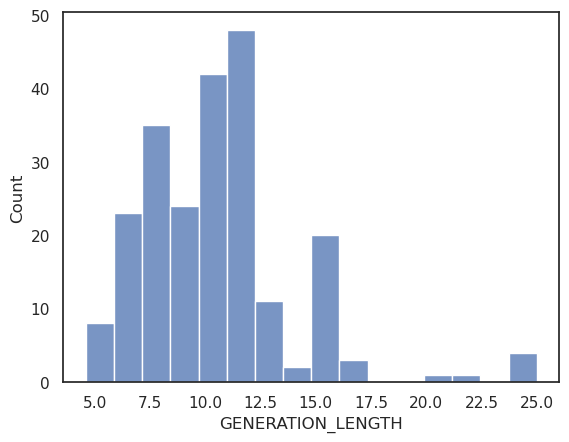

In [8]:
sns.histplot(kuderna_data[col_species_mut].GENERATION_LENGTH)

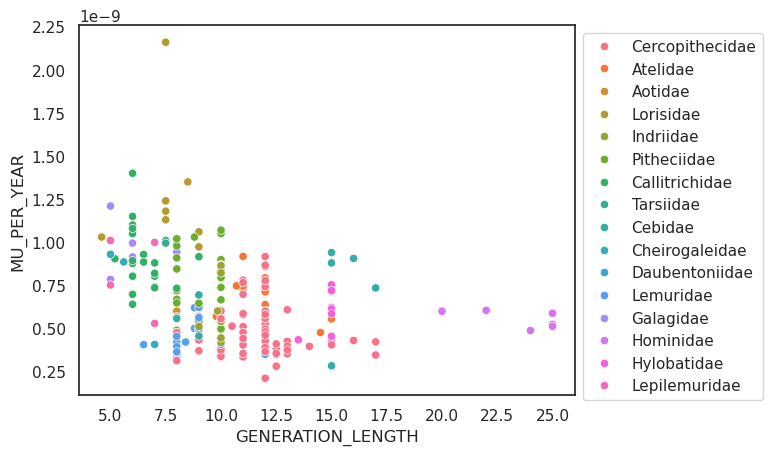

In [9]:
g = sns.scatterplot(data=kuderna_data, x="GENERATION_LENGTH", y="MU_PER_YEAR", hue="FAMILY")
plt.legend(bbox_to_anchor=(1.0, 1))

In [10]:
metadata_dir = "/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/"


metadata_dirs = glob.glob(metadata_dir+"*_individuals.txt")

df_l = []
for d in metadata_dirs:
    # Identify IDs
    dir_metadata = pd.read_csv(d, sep="\t")
    df_l.append(dir_metadata)
all_inds = pd.concat(df_l)

In [11]:
all_inds.loc[all_inds.GVCF_ID == "PD_0629"]

,BIOSAMPLE_ID,PDGP_ID,GVCF_ID,SRA_SAMPLE_ID,BIOPROJECT_ID,BAM_FOLDER,GVCF_FOLDER,REFERENCE_FOLDER,GENUS,SPECIES,...,REPORTED_SEX,GENETIC_SEX,AVG_COVERAGE_GW,PROP_COVERED_GW,AVG_COVERAGE_A,PROP_COVERED_A,AVG_COVERAGE_X,PROP_COVERED_X,AVG_COVERAGE_Y,PROP_COVERED_Y
0,SAMEA112483158,PD_0629,PD_0629,ERS14600509,PRJEB59576,Carlito_syrichta_ssp,Carlito_syrichta_ssp,Cephalopachus_bancanus_ssp,Carlito,syrichta,...,Unknown,Unknown,26.7228,0.9795,26.9096,0.9798,14.8478,0.9583,Unknown,Unknown


In [12]:
df_species_mut.loc[df_species_mut.GENUS == "Carlito"]

,SPECIES_BINOMIAL,GENUS,SPECIES,FAMILY,GENERATION_LENGTH,MU_PER_GENERATION,MU_PER_YEAR,EFFECTIVE_POP_SIZE
32,Carlito_syrichta,Carlito,syrichta,Tarsiidae,7.5,7.580000e-09,1.010000e-09,74616


In [13]:
c_list = []
for p in glob.glob("../steps/cobraa/*"):
    if len(glob.glob(p+"/*final_parameters.txt")) >= 1:
        c_list.append(glob.glob(p+"/*final_parameters.txt")[0])
c_list

['../steps/cobraa/PD_0093/aut_D50_ts28_te34_final_parameters.txt',
 '../steps/cobraa/PD_0346/CM063169.1_final_parameters.txt',
 '../steps/cobraa/PD_0156/HiC_scaffold_1_final_parameters.txt',
 '../steps/cobraa/PD_0121/CM063169.1_final_parameters.txt',
 '../steps/cobraa/PD_0051/aut_D50_ts10_te34_final_parameters.txt',
 '../steps/cobraa/PD_0119/CM063169.1_final_parameters.txt',
 '../steps/cobraa/SAMN23530509/aut_D50_ts4_te40_final_parameters.txt',
 '../steps/cobraa/PD_0009/CM063169.1_final_parameters.txt',
 '../steps/cobraa/PD_0010/aut_D50_ts28_te34_final_parameters.txt',
 '../steps/cobraa/SAMEA2446072/aut_D50_ts4_te28_final_parameters.txt',
 '../steps/cobraa/PD_0313/aut_D50_ts4_te10_final_parameters.txt',
 '../steps/cobraa/SAMN20815322/aut_D50_ts4_te22_final_parameters.txt',
 '../steps/cobraa/SAMN43494761/aut_D50_ts4_te34_final_parameters.txt',
 '../steps/cobraa/PD_0351/CM063169.1_final_parameters.txt',
 '../steps/cobraa/SAMN43494766/aut_D50_ts10_te34_final_parameters.txt',
 '../steps/co

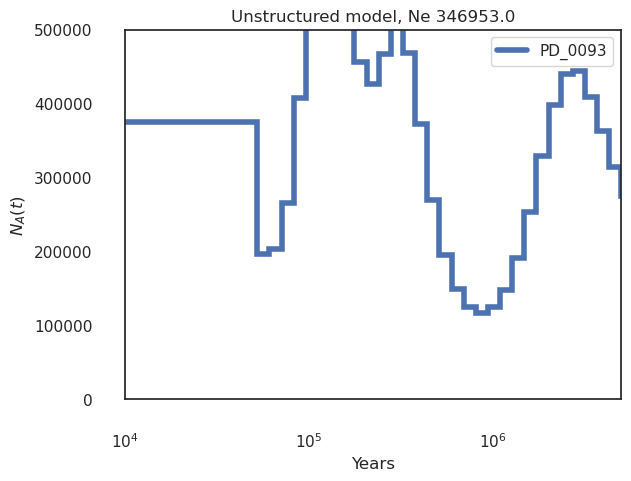

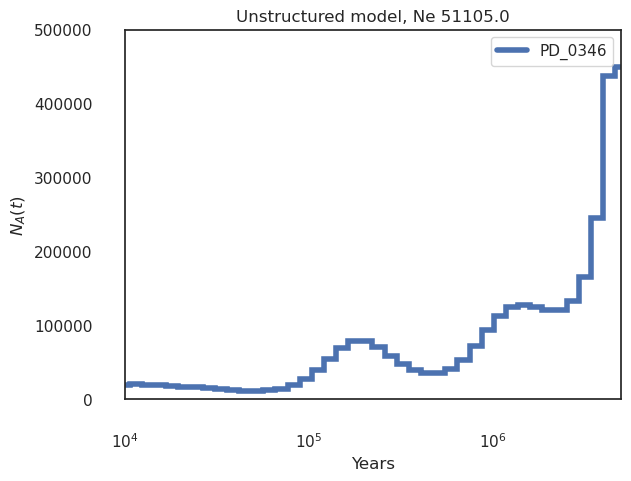

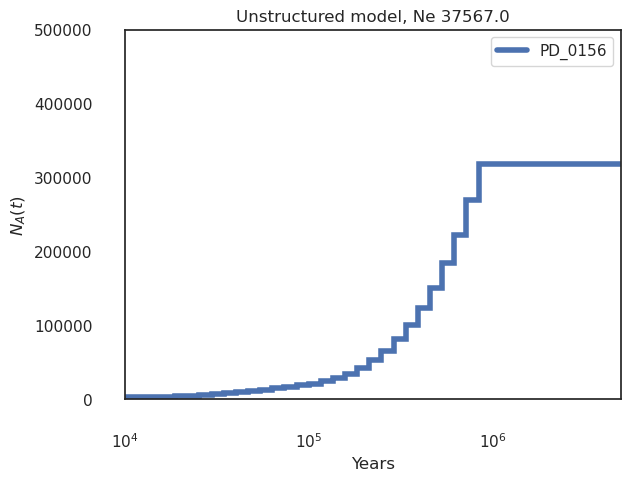

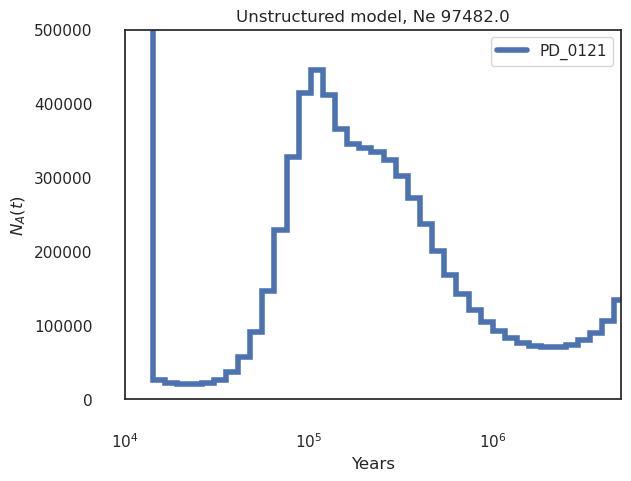

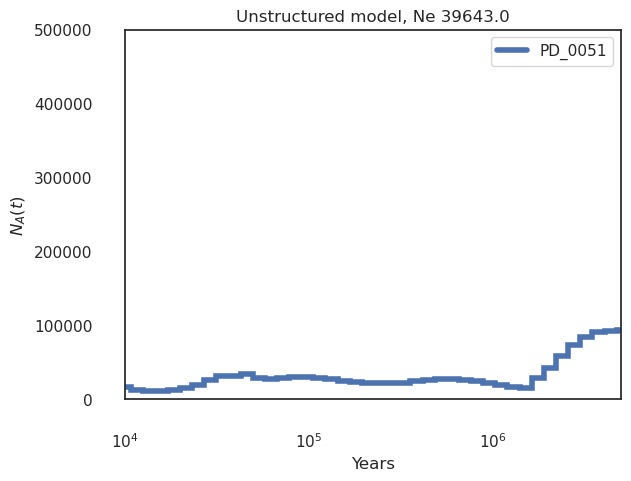

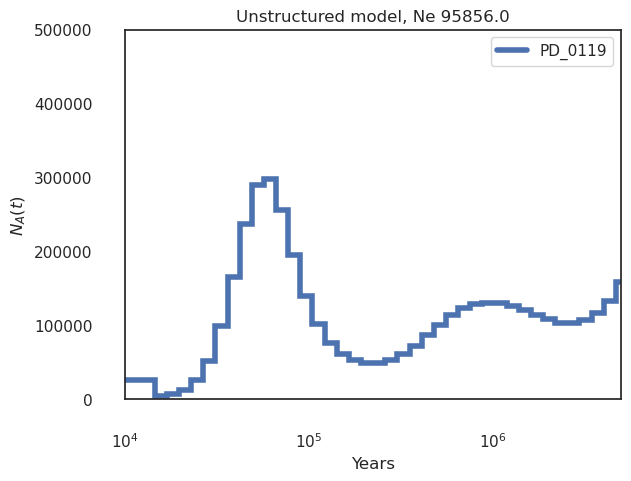

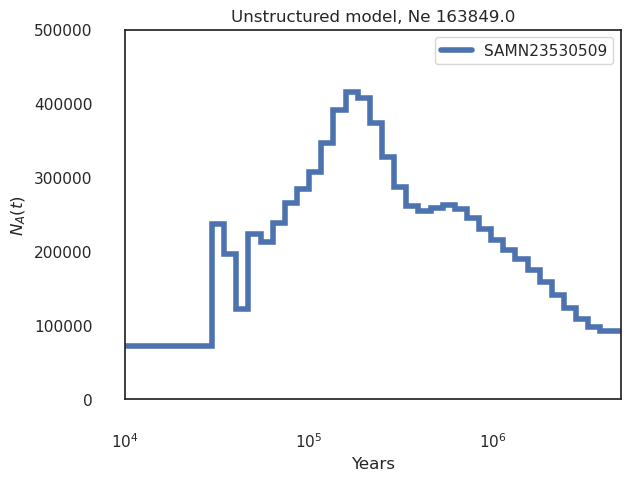

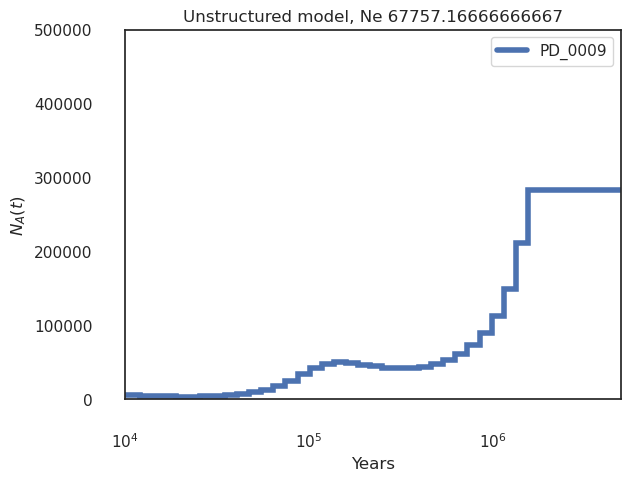

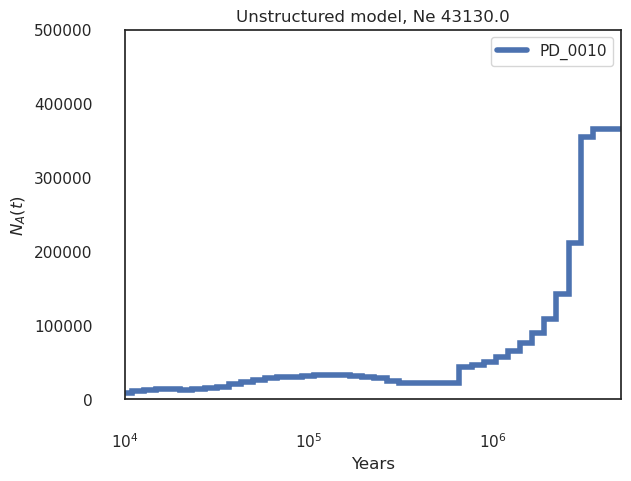

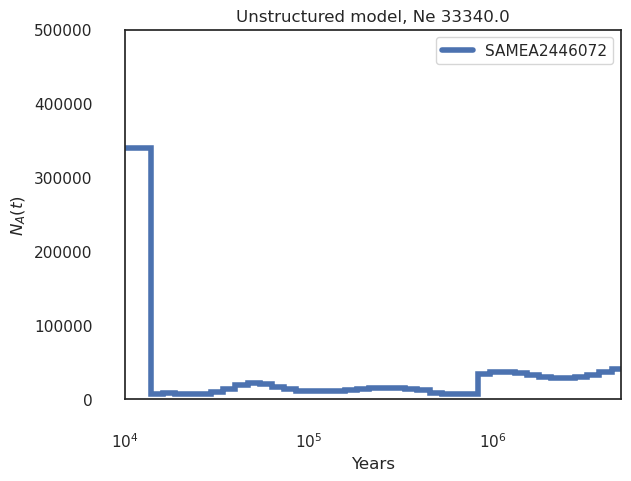

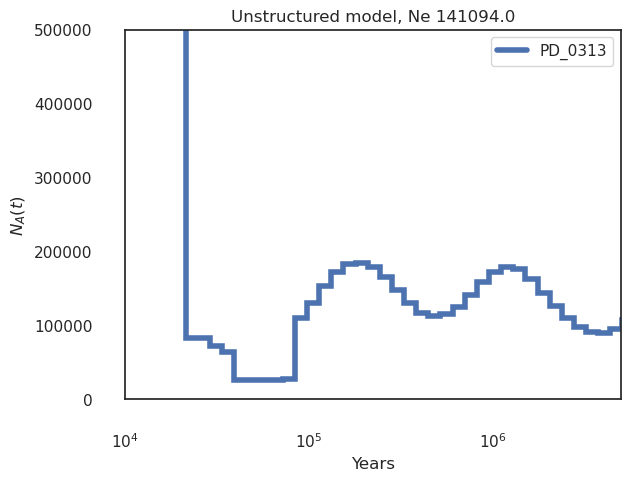

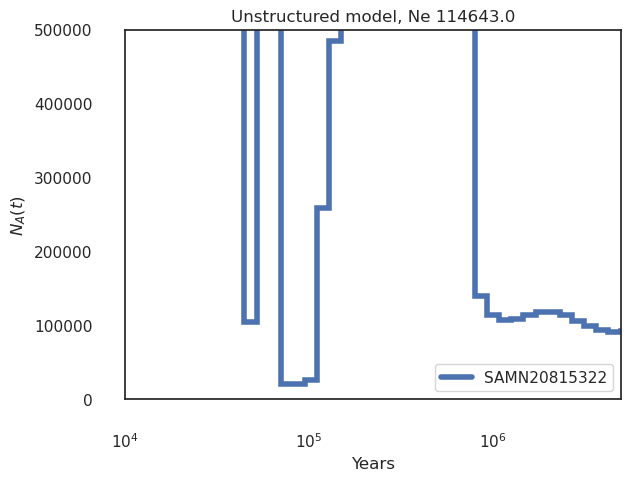

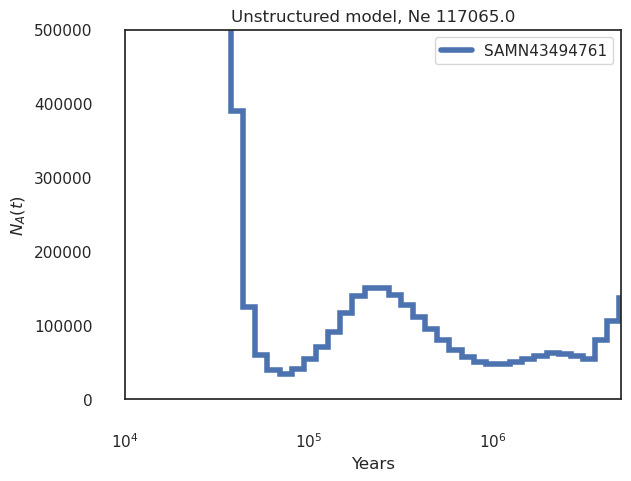

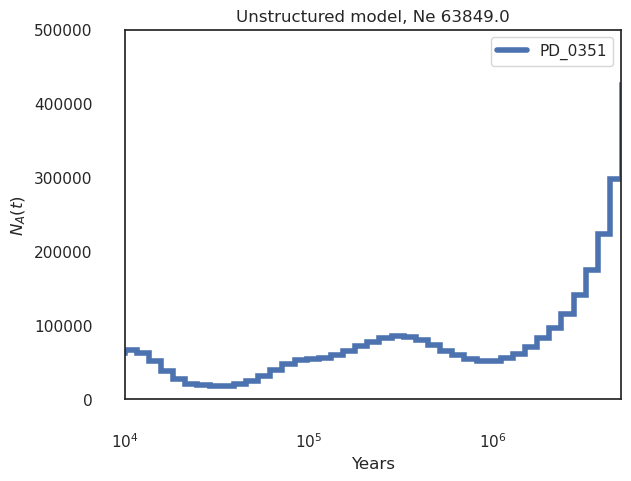

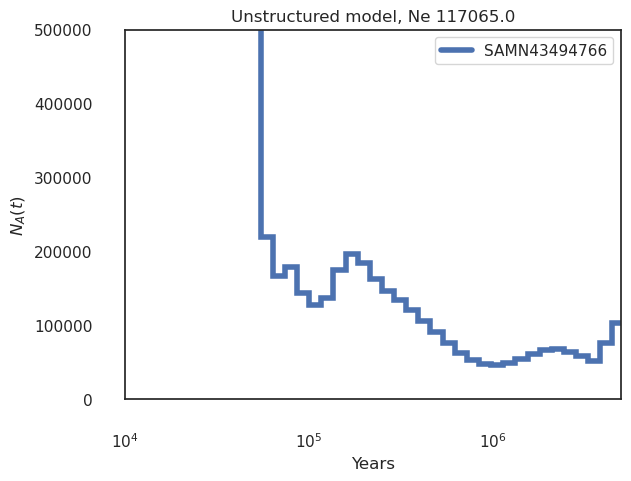

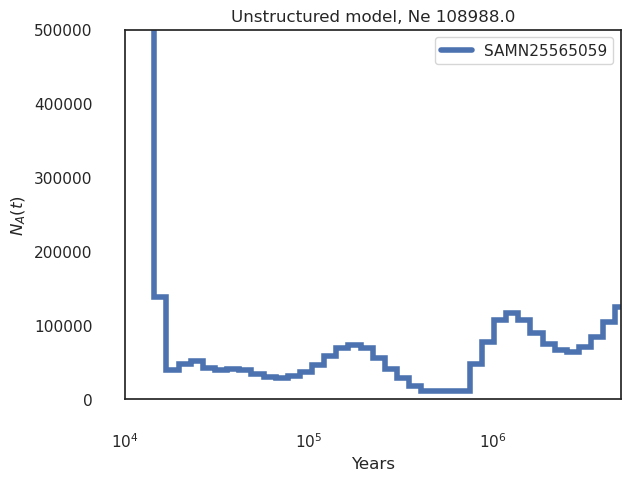

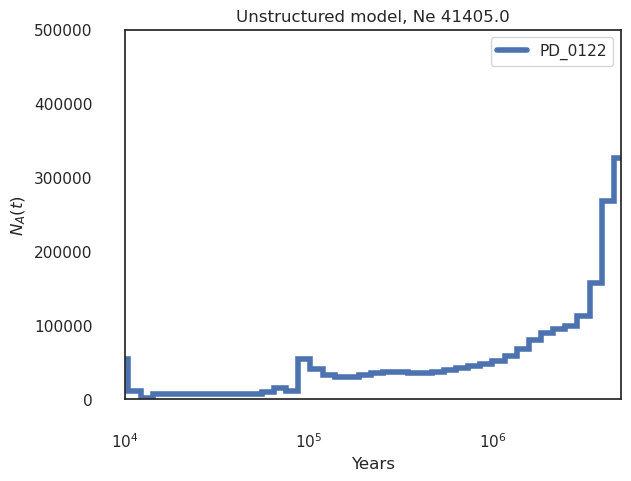

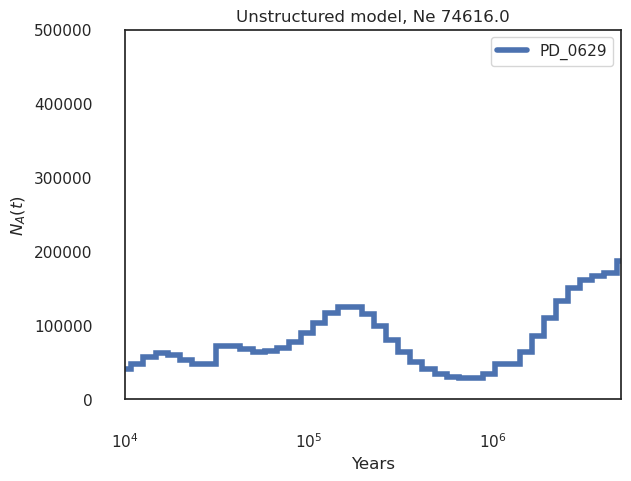

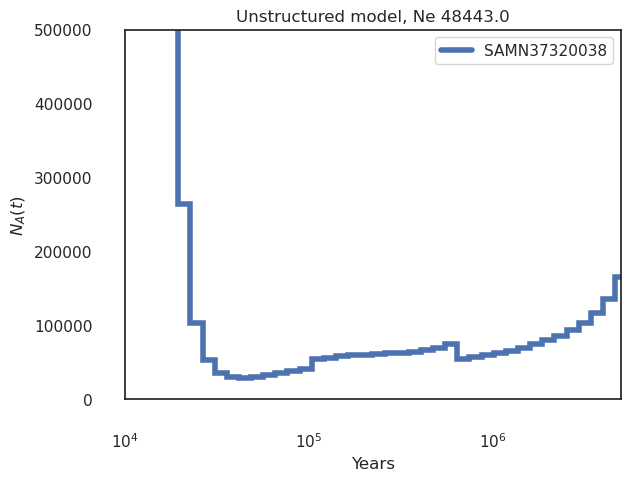

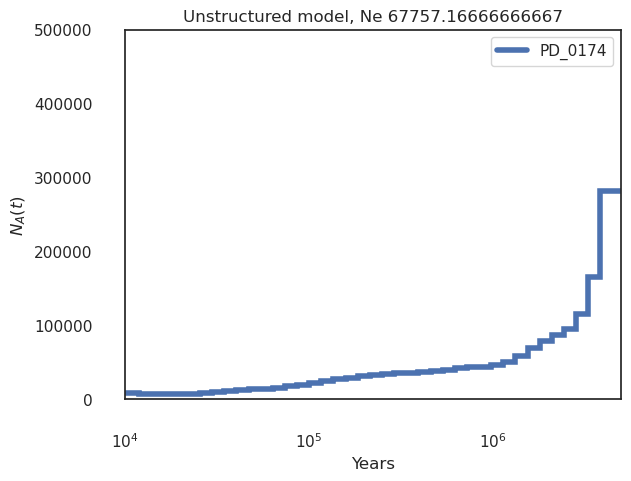

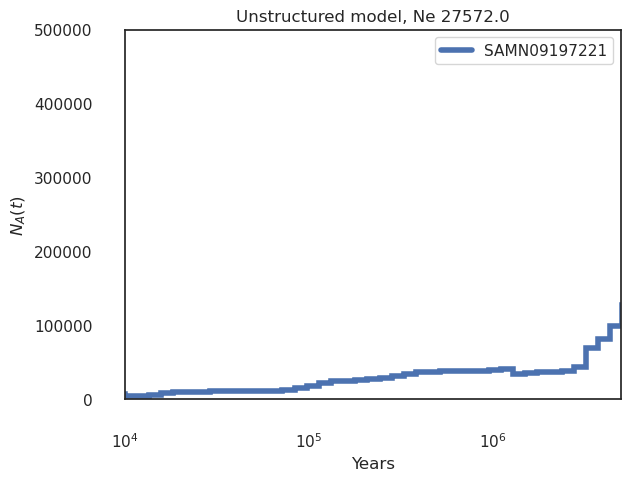

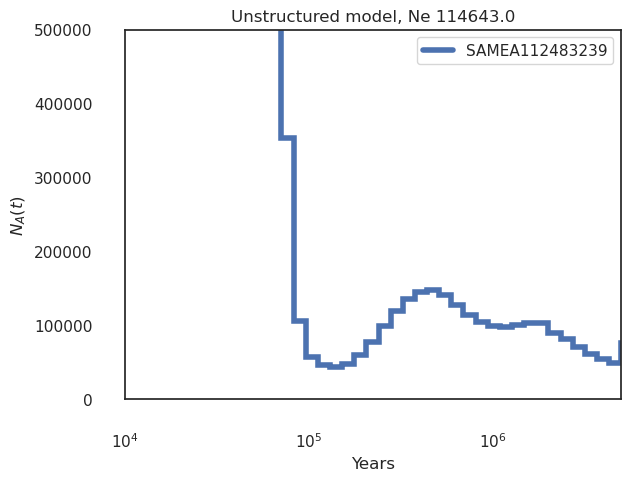

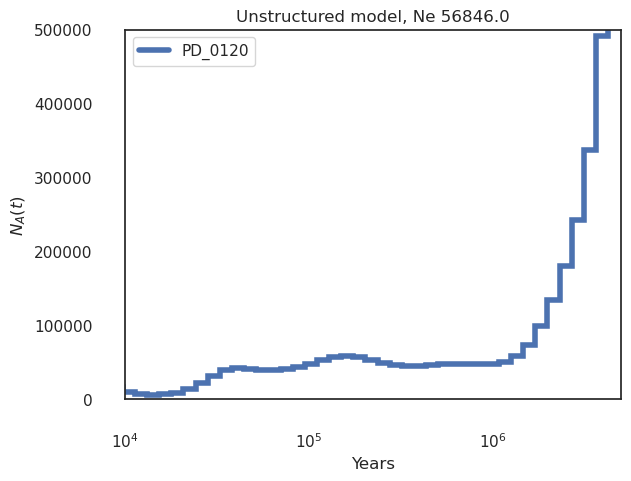

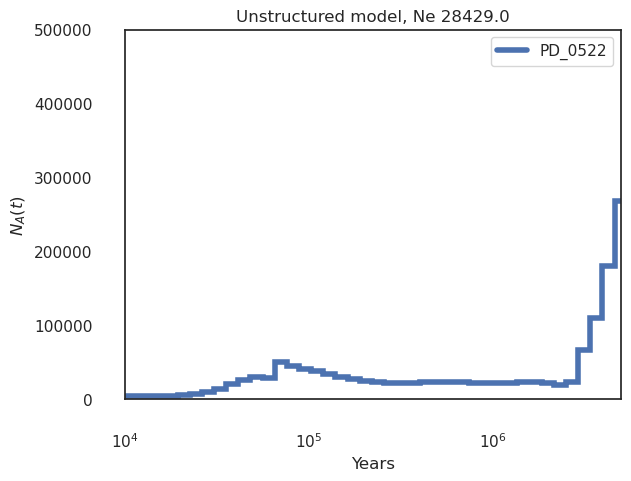

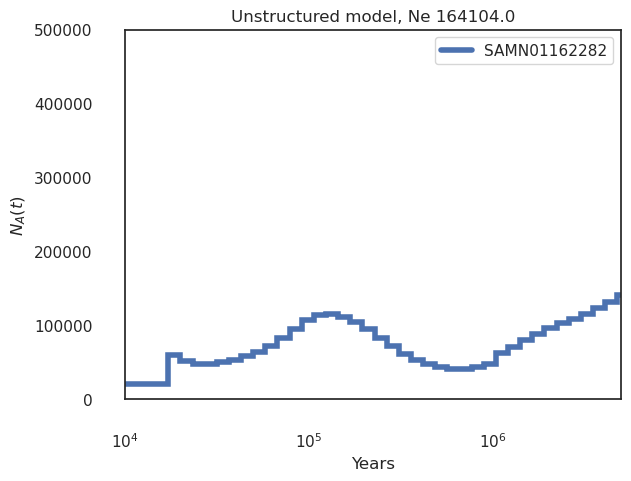

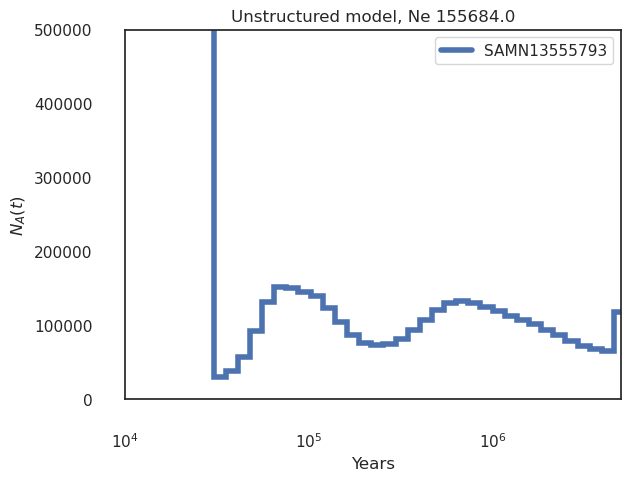

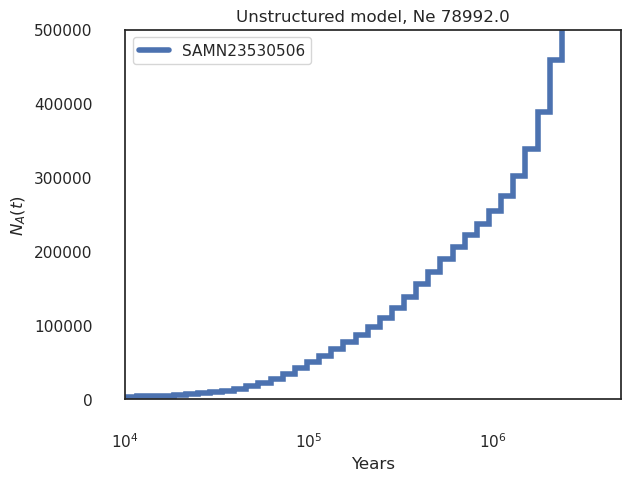

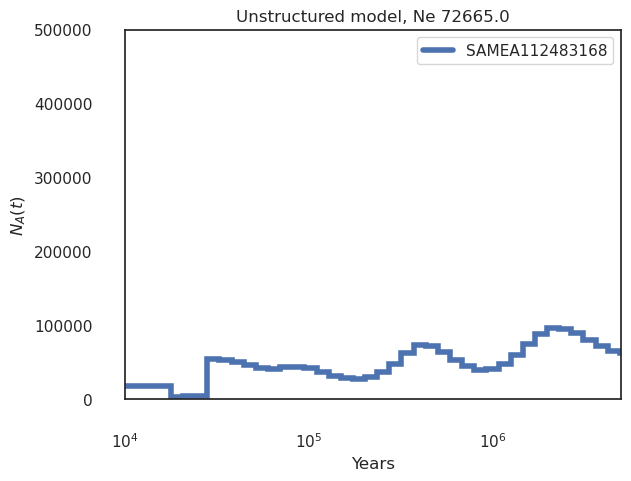

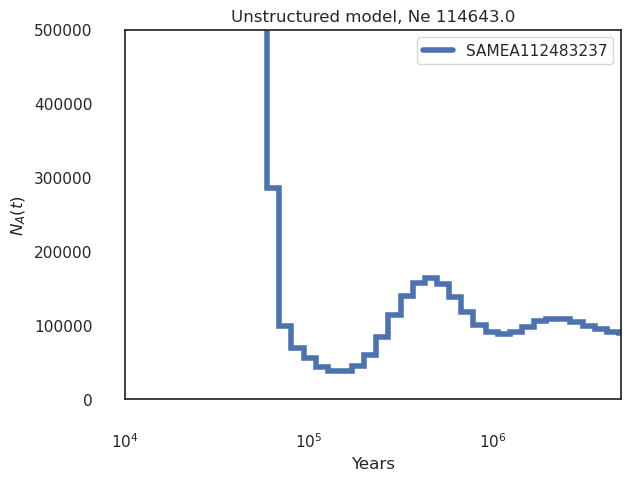

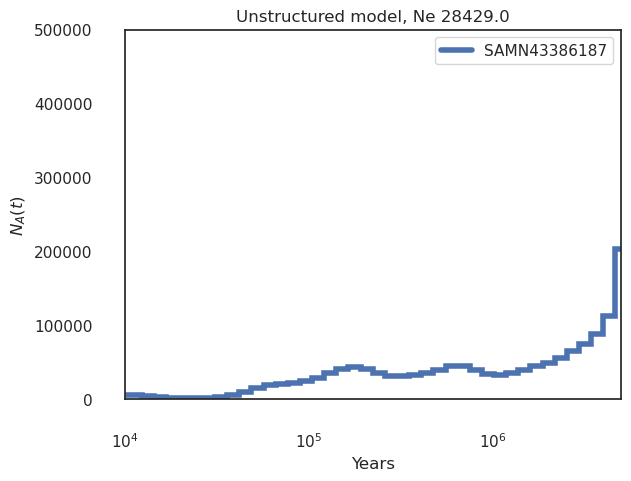

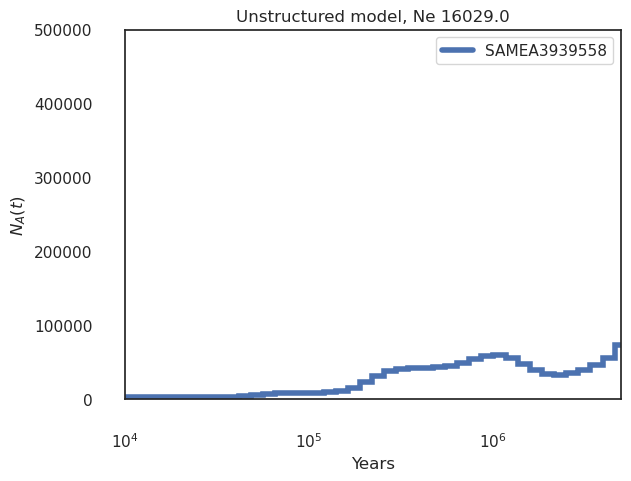

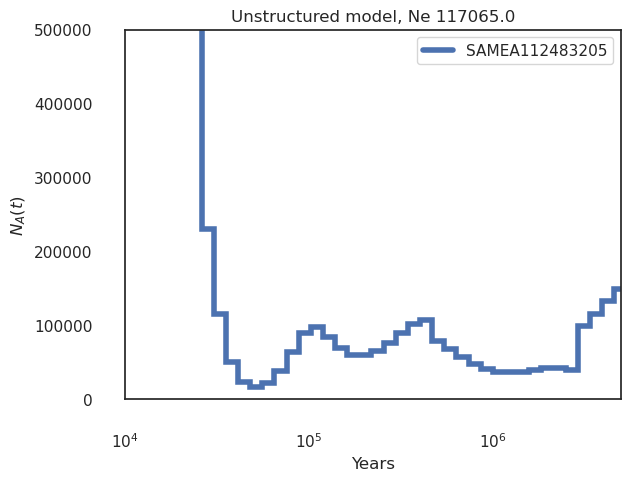

In [14]:
for p in c_list:
    label_tag = p.split("/")[-2]
    ind_inf = all_inds.loc[all_inds.GVCF_ID == label_tag]
    gs = ind_inf.GENUS.iloc[0]+"_"+ind_inf.SPECIES.iloc[0]
    gs_df = df_species_mut.loc[df_species_mut.SPECIES_BINOMIAL == gs]
    g_df = df_species_mut.loc[df_species_mut.GENUS == ind_inf.GENUS.iloc[0]] 
    if len(gs_df) > 0:
        mu = gs_df.MU_PER_GENERATION.mean()
        gen = gs_df.GENERATION_LENGTH.mean()
        kuderna_Ne = gs_df.EFFECTIVE_POP_SIZE.mean()
    elif len(g_df) > 0:
        mu = g_df.MU_PER_GENERATION.mean()
        gen = g_df.GENERATION_LENGTH.mean()
        kuderna_Ne = g_df.EFFECTIVE_POP_SIZE.mean()
    else:
        print(gs)
        continue
    final_params_file = p
    final_params = np.loadtxt(final_params_file)
    time_array = list(final_params[:,1])
    time_array.insert(0,0)
    time_array = np.array(time_array)
    plt.stairs(edges=(time_array/mu)*gen,values=(1/final_params[:,2])/mu,label=label_tag,linewidth=4,linestyle="solid",baseline=None)
    plt.xlim(1e+04,5e+06)
    plt.ylim(0,50e+04)
    plt.xscale('log')
    plt.ylabel('$N_A(t)$')
    plt.xlabel('Years')
    plt.tick_params(which='major',length=20)
    plt.tick_params(which='minor',length=10)
    plt.legend(ncol=2)
    plt.title('Unstructured model, Ne {}'.format(kuderna_Ne))
    plt.show()

In [15]:
final_params_file

'../steps/cobraa/SAMEA112483205/aut_D50_ts22_te34_final_parameters.txt'

In [16]:
ind_inf

,BIOSAMPLE_ID,PDGP_ID,GVCF_ID,SRA_SAMPLE_ID,BIOPROJECT_ID,BAM_FOLDER,GVCF_FOLDER,REFERENCE_FOLDER,GENUS,SPECIES,...,REPORTED_SEX,GENETIC_SEX,AVG_COVERAGE_GW,PROP_COVERED_GW,AVG_COVERAGE_A,PROP_COVERED_A,AVG_COVERAGE_X,PROP_COVERED_X,AVG_COVERAGE_Y,PROP_COVERED_Y
47,SAMEA112483205,PD_0738,SAMEA112483205,ERS14600556,PRJEB59576,Papio_anubis_ssp,Papio_anubis_ssp,Papio_anubis_ssp,Papio,anubis,...,F,F,41.2441,0.9847,41.2146,0.9883,41.7917,0.9678,41.1584,0.1586


Structured check

In [17]:
# Files used
glob.glob("../steps/cobraa/PD_0629/aut_D50*")

['../steps/cobraa/PD_0629/aut_D50_ts10_te34_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts10_te16_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts16_te28_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts4_te40_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts22_te40_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts16_te34_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts34_te40_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts10_te28_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts28_te40_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts16_te22_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts10_te22_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts4_te22_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts28_te34_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts16_te40_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts22_te34_final_parameters.txt

In [18]:
def get_gamma_from_file(file):
    lines = !cat {file}
    return float([i for i in lines if 'gamma' in i][0].split(' ')[-1])
    
def get_LL_from_file(filename):
    with open(filename) as f:
        lines = f.readlines()
    return float([i for i in lines if 'likelihood' in i and 'final' in i][0].split(' ')[-1])

for p in glob.glob("../steps/cobraa/PD_0313/aut_fi*"):
    print(get_LL_from_file(p), p)
    aut_LL = get_LL_from_file(p)

for p in glob.glob("../steps/cobraa/PD_0313/aut_D5*"):
    print(get_gamma_from_file(p), get_LL_from_file(p)-aut_LL, p)
    

-3165403.5865531787 ../steps/cobraa/PD_0313/aut_final_parameters.txt
0.4962136959658122 -5.37241280451417 ../steps/cobraa/PD_0313/aut_D50_ts4_te10_final_parameters.txt
0.05282088417992215 171.48858986236155 ../steps/cobraa/PD_0313/aut_D50_ts34_te40_final_parameters.txt
0.36312073563469116 1303.247873544693 ../steps/cobraa/PD_0313/aut_D50_ts10_te28_final_parameters.txt
0.33667853489263483 1198.711476684548 ../steps/cobraa/PD_0313/aut_D50_ts4_te28_final_parameters.txt
0.12098728072522144 470.99925832264125 ../steps/cobraa/PD_0313/aut_D50_ts16_te34_final_parameters.txt
0.014834809181644764 6.753147688694298 ../steps/cobraa/PD_0313/aut_D50_ts22_te40_final_parameters.txt
0.44104384367556476 -3.1520788986235857 ../steps/cobraa/PD_0313/aut_D50_ts10_te16_final_parameters.txt
0.38493595080358733 1222.7063154885545 ../steps/cobraa/PD_0313/aut_D50_ts16_te28_final_parameters.txt
0.11091481744125618 354.3111547762528 ../steps/cobraa/PD_0313/aut_D50_ts4_te34_final_parameters.txt
0.11781939078888408 

In [19]:
f = open("../steps/cobraa/PD_0313/aut_D50_ts10_te28_final_parameters.txt", "r")
print(f.readlines()[:9])

['# final log likelihood = -3164100.338679634\n', '# final change in log likelihood = 63.564694113098085\n', '# number of iterations taken = 20\n', '# theta=4*N_E*mu = 0.0025184377263154454\n', '# rho=4*N_E*r = 0.0011692306313039718\n', '# scale time by dividing by mu\n', '# scale lambda by taking its inverse then dividing by mu\n', '# col 0 is left time boundary; col 1 is right time boundary; col 3 is scaled_lambda_A; col 4 is scaled_lambda_B\n', '0.000000000000000000e+00 1.158101829227505153e-05 3.666983874751247754e+02 3.177232807655425972e+02\n']


In [20]:
f = open("../steps/cobraa/PD_0313/aut_D50_ts10_te28_final_parameters.txt", "r")
print(f.readlines()[-2])

1.709794645466339302e-02 1.990530765736224159e-02 7.085318807627650131e+03 3.177232807655425972e+02



In [21]:
final_params_file = "../steps/cobraa/PD_0313/aut_D50_ts10_te28_final_parameters.txt"
with open(final_params_file) as f:
    finallines = f.readlines()
ztheta = float([i for i in finallines if 'theta' in i ][0].split(' ')[-1])
zrho = float([i for i in finallines if 'rho' in i ][0].split(' ')[-1])
zgamma = float([i for i in finallines if 'gamma' in i ][0].split(' ')[-1])
    
final_params = np.loadtxt(final_params_file)
lambdaA_parameters = final_params[:,2]*ztheta/4
lambdaB_parameters = final_params[:,3]*ztheta/4

In [22]:
np.loadtxt(final_params_file)

array([[0.00000000e+00, 1.15810183e-05, 3.66698387e+02, 3.17723281e+02],
       [1.15810183e-05, 1.34825391e-05, 1.89303741e+03, 3.17723281e+02],
       [1.34825391e-05, 1.56962762e-05, 1.95750523e+03, 3.17723281e+02],
       [1.56962762e-05, 1.82734931e-05, 2.37850139e+03, 3.17723281e+02],
       [1.82734931e-05, 2.12738707e-05, 3.19804165e+03, 3.17723281e+02],
       [2.12738707e-05, 2.47668889e-05, 4.13473110e+03, 3.17723281e+02],
       [2.47668889e-05, 2.88334359e-05, 4.63185974e+03, 3.17723281e+02],
       [2.88334359e-05, 3.35676810e-05, 4.44031499e+03, 3.17723281e+02],
       [3.35676810e-05, 3.90792555e-05, 3.89608217e+03, 3.17723281e+02],
       [3.90792555e-05, 4.54957914e-05, 3.38518595e+03, 3.17723281e+02],
       [4.54957914e-05, 5.29658767e-05, 4.45477662e+03, 3.17723281e+02],
       [5.29658767e-05, 6.16624970e-05, 3.96856284e+03, 3.17723281e+02],
       [6.16624970e-05, 7.17870404e-05, 3.50213168e+03, 3.17723281e+02],
       [7.17870404e-05, 8.35739619e-05, 3.11323362e

In [23]:
",".join([str(x) for x in final_params[:,2]*ztheta/4])

'0.23087676329909837,1.1918742059065959,1.2324637538530463,1.4975269054234883,2.013517182955232,2.603265696417167,2.916262576871493,2.7956641998139875,2.4530100832472423,2.131345000420639,2.8047693763893826,2.4986445965674364,2.2049751367126547,1.9601212473127851,1.7757973345217892,1.6316073877975024,1.5416348903595376,1.5341022814711742,1.6211688137580522,1.8018550600896968,2.0751550845875824,2.450810092832128,2.9629264717989745,3.69439285465338,4.837739114815185,4.999961949487317,4.9999340463444275,4.999939186253933,0.9570683450224202,0.9727296806791061,1.020029292482623,1.097893810351519,1.196029533773705,1.2944362192323147,1.3628107145600208,1.371598289542252,1.3065368684976435,1.177724974495165,1.0128708187166082,0.8435003948389052,0.6856586966925501,0.530946841486948,0.3685412303389101,0.2192959759858522,0.11562667557439815,0.10003688436919514,0.10003688436919514,0.10003688436919514,0.10003688436919514,4.46098354702546'

In [24]:
len(lambdaB_parameters)

50

In [25]:
ztheta, zrho, zgamma

(0.0025184377263154454, 0.0011692306313039718, 0.36312073563469116)

In [26]:
#PD_0010: Likelihoods can both be better and worse than unstructured.
-1442522.7799575876-(-1442661.2414622284), -1442684.337433766-(-1442661.2414622284)

(138.46150464075617, -23.09597153775394)

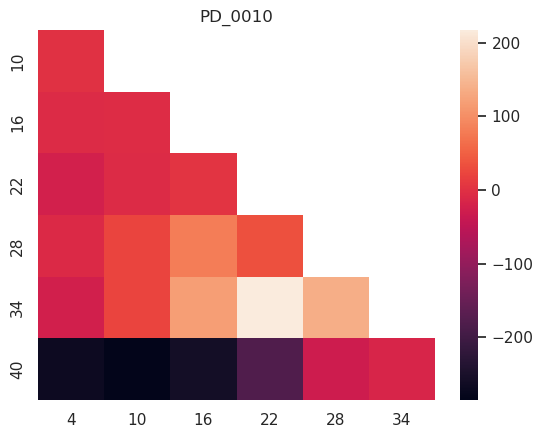

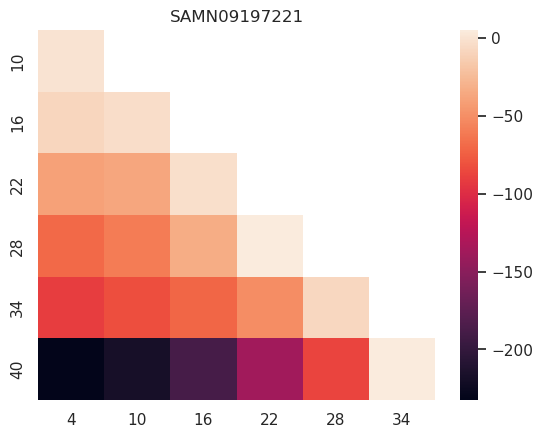

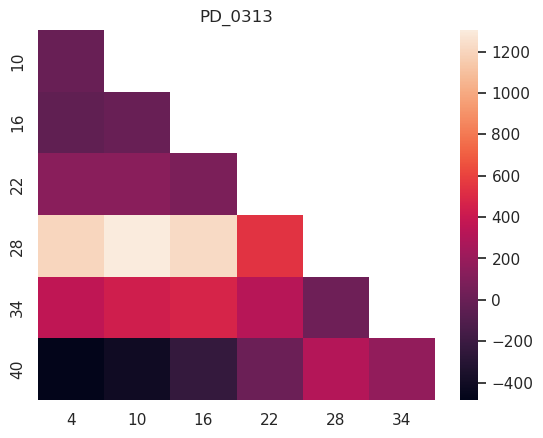

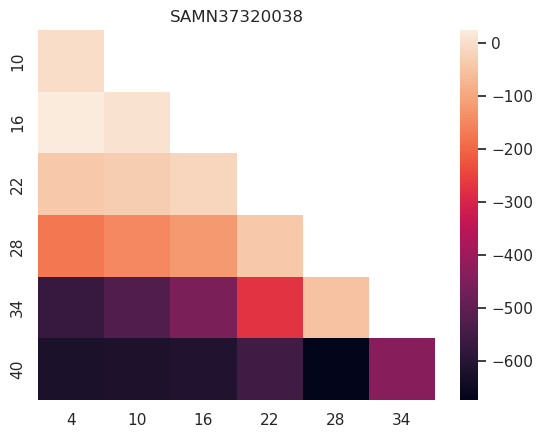

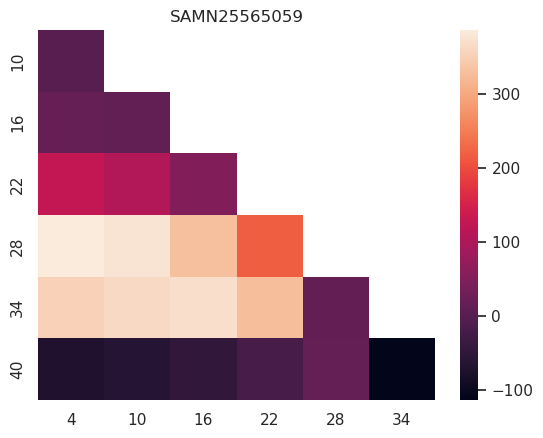

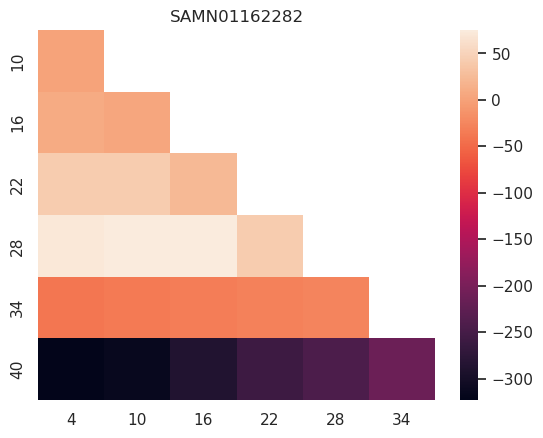

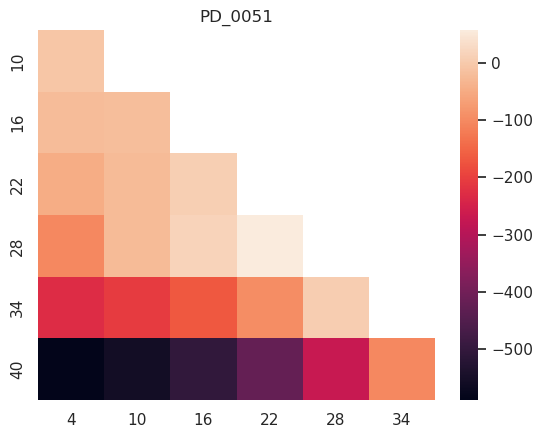

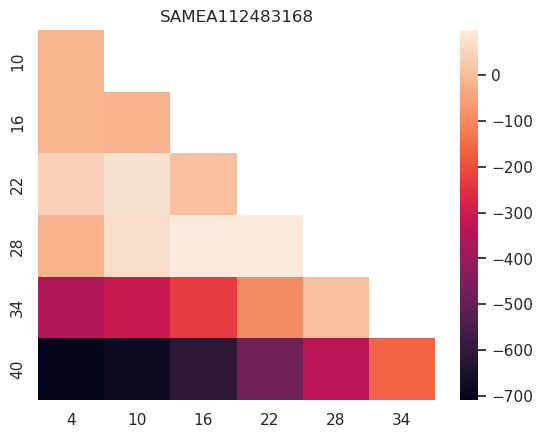

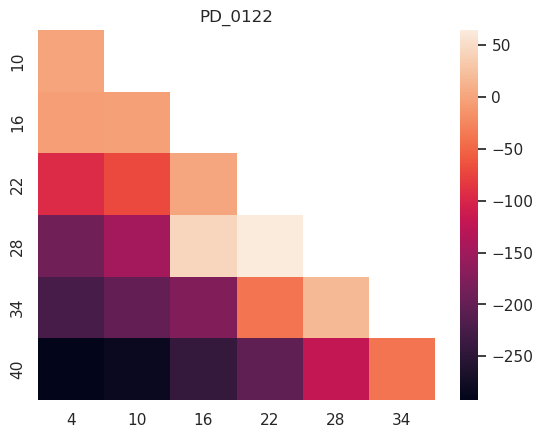

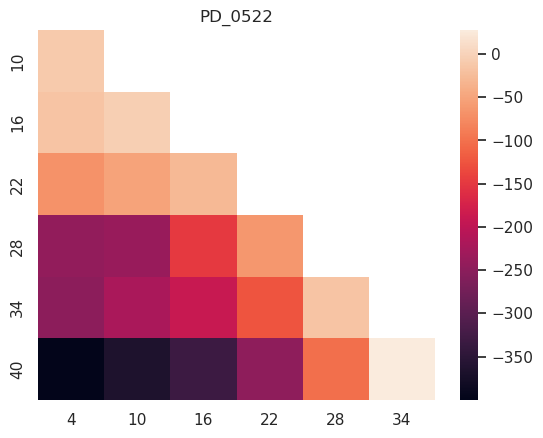

<Figure size 640x480 with 0 Axes>

In [27]:
for ind in ["PD_0010", "SAMN09197221", "PD_0313", "SAMN37320038", "SAMN25565059",
           "SAMN01162282", "PD_0051", "SAMEA112483168", "PD_0122", "PD_0522"]:
    final_params_file_pan = f'../steps/cobraa/{ind}/aut_final_parameters.txt'
    pan_LL = get_LL_from_file(final_params_file_pan)
    matrix_LL_diffs = np.zeros(shape=(6,6))
    matrix_LL_diffs[:] = np.nan
    for te in range(10, 42, 6):
        for ts in range(4, te-4, 6):
            final_params_file_struct = f'../steps/cobraa/{ind}/aut_D50_ts{ts}_te{te}_final_parameters.txt'
            struct_LL = get_LL_from_file(final_params_file_struct)
            diff_LL = struct_LL - pan_LL
            matrix_LL_diffs[int((te-6)/6),int(ts/6)] = diff_LL
    matrix_LL_diffs = matrix_LL_diffs
    g = sns.heatmap(matrix_LL_diffs)
    g.set(xticklabels=list(range(4, te-4, 6)), yticklabels=list(range(10, 42, 6)),title=ind)
    plt.figure()

In [28]:
matrix_LL_diffs

array([[ -10.08007782,           nan,           nan,           nan,
                  nan,           nan],
       [ -17.160373  ,   -5.85190262,           nan,           nan,
                  nan,           nan],
       [ -67.79226323,  -52.26071701,  -29.04771889,           nan,
                  nan,           nan],
       [-244.23448636, -237.91657671, -148.5139991 ,  -64.28079348,
                  nan,           nan],
       [-248.43192286, -220.74301042, -190.00395127, -126.02551631,
         -15.9975515 ,           nan],
       [-399.98256782, -365.67118595, -332.08006798, -246.82966856,
        -102.01613357,   27.48199221]])

Decode checks

In [29]:


def get_all_A_indices(D_flat,ts,te):
    pre_struct = [i for i in range(0,ts)]
    in_struct = [ts + (j)*2 for j in range(0,te-ts)]
    post_struct = [ts + (te-ts)*2 + (j)*3 for j in range(0,D-te)]
    all_A_indices = pre_struct + in_struct + post_struct
    return all_A_indices

def get_all_B_indices(D_flat,ts,te):
    in_struct = [ts + ((j)*2+1) for j in range(0,te-ts)]
    post_struct = [ts + (te-ts)*2+ (j)*3+1 for j in range(0,D-te)]
    all_B_indices = in_struct + post_struct
    return all_B_indices


def get_AB_poststruct_indices(D_flat,ts,te):
    AB_indices = [ts + (te-ts)*2 + (j)*3+2 for j in range(0,D-te)]
    return AB_indices

In [30]:
D = 50 # number of discrete time intervals in the HMM
T_1 = 10 # composite ML estimate of admixture time
T_2 = 28 # composite ML estimate of divergence time
T_2_flat = T_1+(T_2-T_1)*2 # index of T_2 in flatten HMM transition matrix
D_flat = T_1 + (T_2-T_1)*2 + (D-T_2)*3 # number of indices in posterior decoding; there are 32 time intervals and T_1 and T_2 are 13 and 21 respectively. Before T_1 only c=AA is possible; between T_1 and T_2 c=AA or C=BB is possible; after T_2 c=AA, c=BB and c=AB are possible
all_A = get_all_A_indices(D_flat,T_1,T_2) # indices of c=AA
all_B = get_all_B_indices(D_flat,T_1,T_2) # indices of c=BB ( implicitly, t>T_1 for c=BB to have non zero probability)
all_AB = get_AB_poststruct_indices(D_flat,T_1,T_2) # indices of c=AB
all_A_given_t_bigger_ts = [i for i in all_A if i>=T_1] # indices of c=AA and t>T_1
all_A_given_t_bigger_te = [i for i in all_A if i>=T_2_flat] # indices of c=AA and t>T_2
all_B_given_t_bigger_te = [i for i in all_B if i>=T_2_flat] # indices of c=B and t>T_2
all_AB_given_t_bigger_te = [i for i in all_AB if i>=T_2_flat] # indices of c=AB and t>T_2
all_A_given_t_bigger_ts_smaller_te = [i for i in all_A if i>=T_1 and i<T_2_flat] # indices of c=AA and T_1<t<T_2
all_B_given_t_bigger_ts_smaller_te = [i for i in all_B if i>=T_1 and i<T_2_flat] # indices of c=BB and T_1<t<T_2
t_in_structured_period = [i for i in range(T_1,T_2_flat)] # index of t for structured period
step_size=400*25 # length between base pairs of posterior decoding

In [31]:

decode_file = "../steps/cobraa/PD_0313/aut_CM080815.1_decode.txt"# change to path of decoding file
decode = np.loadtxt(decode_file) # load file
decode_position = decode[0,:] # get the genomic position
posterior = decode[1:,:] # get the full posterior, this must sum to 1

prob_AA_marginal = posterior[all_A,:].sum(axis=0) # P(c=AA|X)
prob_BB_marginal = posterior[all_B,:].sum(axis=0) # P(c=BB|X)
prob_AB_marginal = posterior[all_AB,:].sum(axis=0) # # P(c=AB|X)

In [32]:
prob_BB_marginal.argmax()

399

In [33]:
prob_AA_marginal.sum(), prob_BB_marginal.sum(), prob_AB_marginal.sum()

(9345.824345827277, 3400.412920345384, 10763.762733827338)

In [34]:
step_size*100

1000000

In [ ]:
start = 100
end = 500
num_xticks = 5
xtickslocs = np.linspace(start,end,num_xticks) - start
xtickslabs = [i for i in np.linspace(start,end,num_xticks)*step_size]

plt.rcParams['figure.figsize'] = [24, 12] 
plt.rcParams.update({'font.size': 25})

np.linspace(start,end,num_xticks)*step_size

# full posterior (coalescence times and lineage paths)
ax = sns.heatmap(posterior[:,start:end],cbar_kws={'label': 'Probability'})
# ax.set_yticks(ticks=ydom,labels=yticks_labs,rotation='horizontal')
ax.set_xticks(ticks=xtickslocs,labels=xtickslabs,rotation='horizontal')
ax.set_xlabel('Chromosome')
ax.set_ylabel('Coalescence times and ancestral lineage path')
ax.invert_yaxis()
ax.set_title('Full posterior')

plt.show()

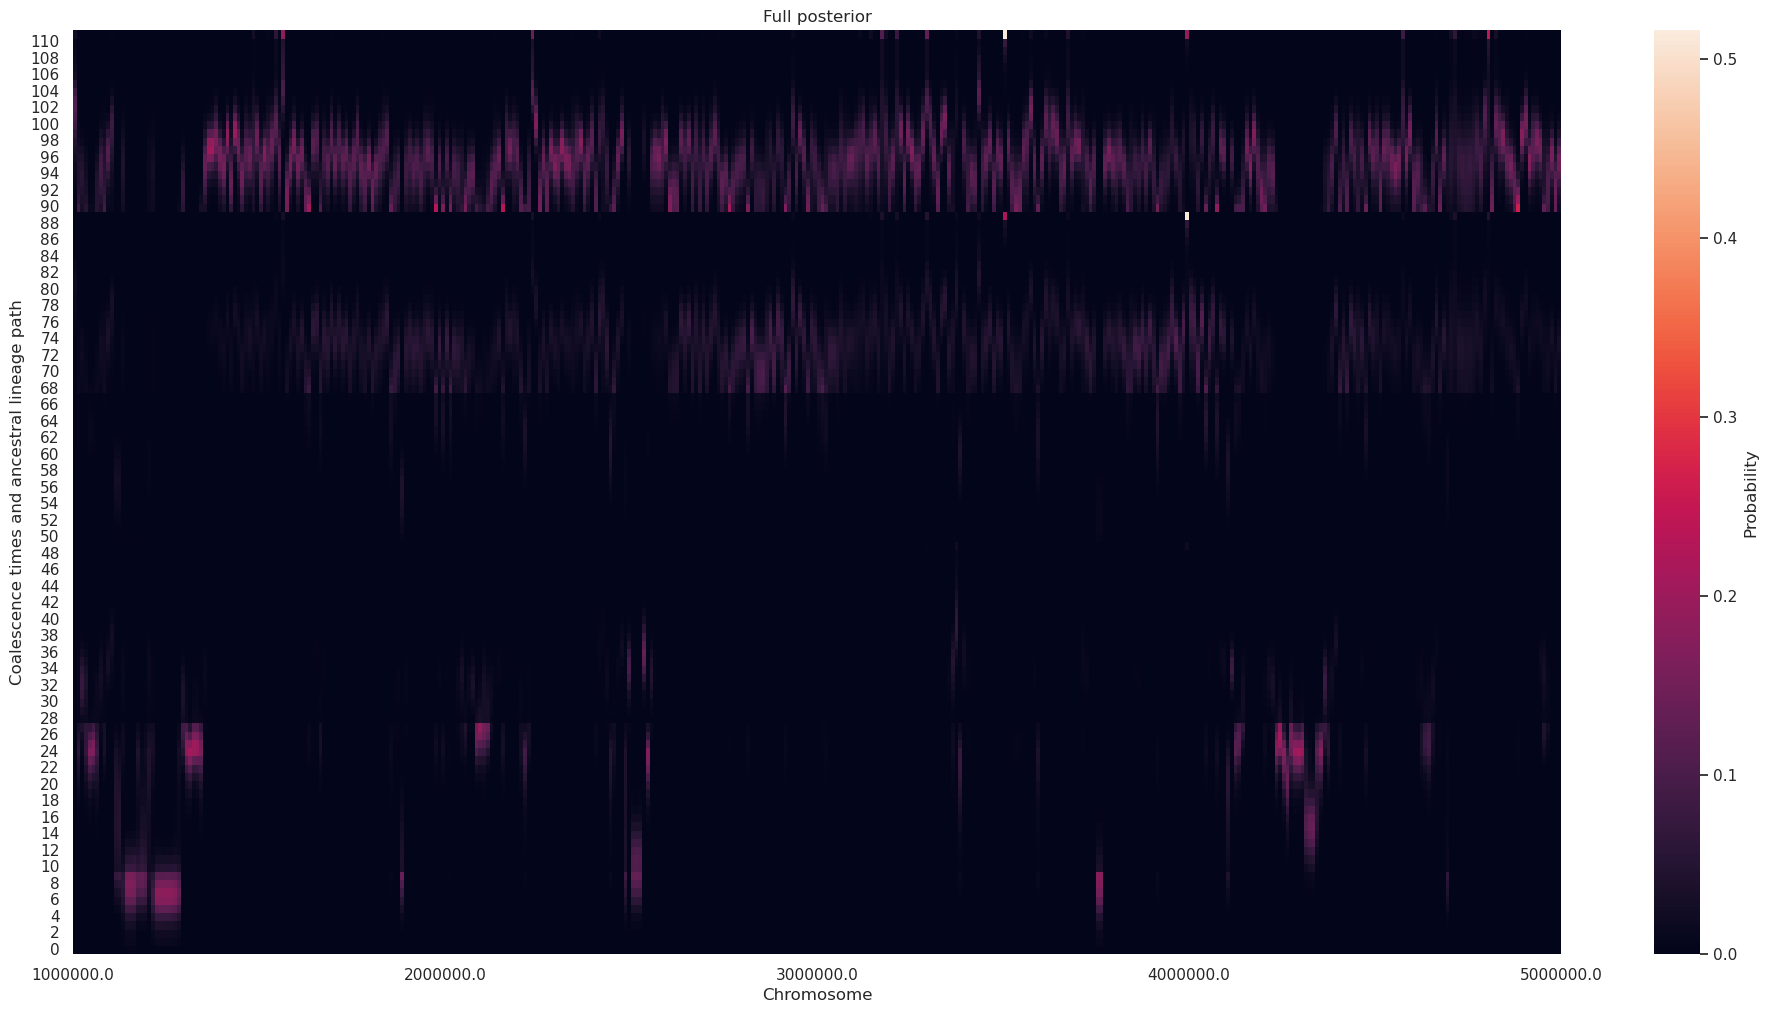

In [36]:
start = 100
end = 500
num_xticks = 5
xtickslocs = np.linspace(start,end,num_xticks) - start
xtickslabs = [i for i in np.linspace(start,end,num_xticks)*step_size]

plt.rcParams['figure.figsize'] = [24, 12] 
plt.rcParams.update({'font.size': 25})

np.linspace(start,end,num_xticks)*step_size

# full posterior (coalescence times and lineage paths)
ax = sns.heatmap(np.concatenate([posterior[all_A,:], posterior[all_B,:], posterior[all_AB,:]])[:,start:end],cbar_kws={'label': 'Probability'})
# ax.set_yticks(ticks=ydom,labels=yticks_labs,rotation='horizontal')
ax.set_xticks(ticks=xtickslocs,labels=xtickslabs,rotation='horizontal')
ax.set_xlabel('Chromosome')
ax.set_ylabel('Coalescence times and ancestral lineage path')
ax.invert_yaxis()
ax.set_title('Full posterior')

plt.show()

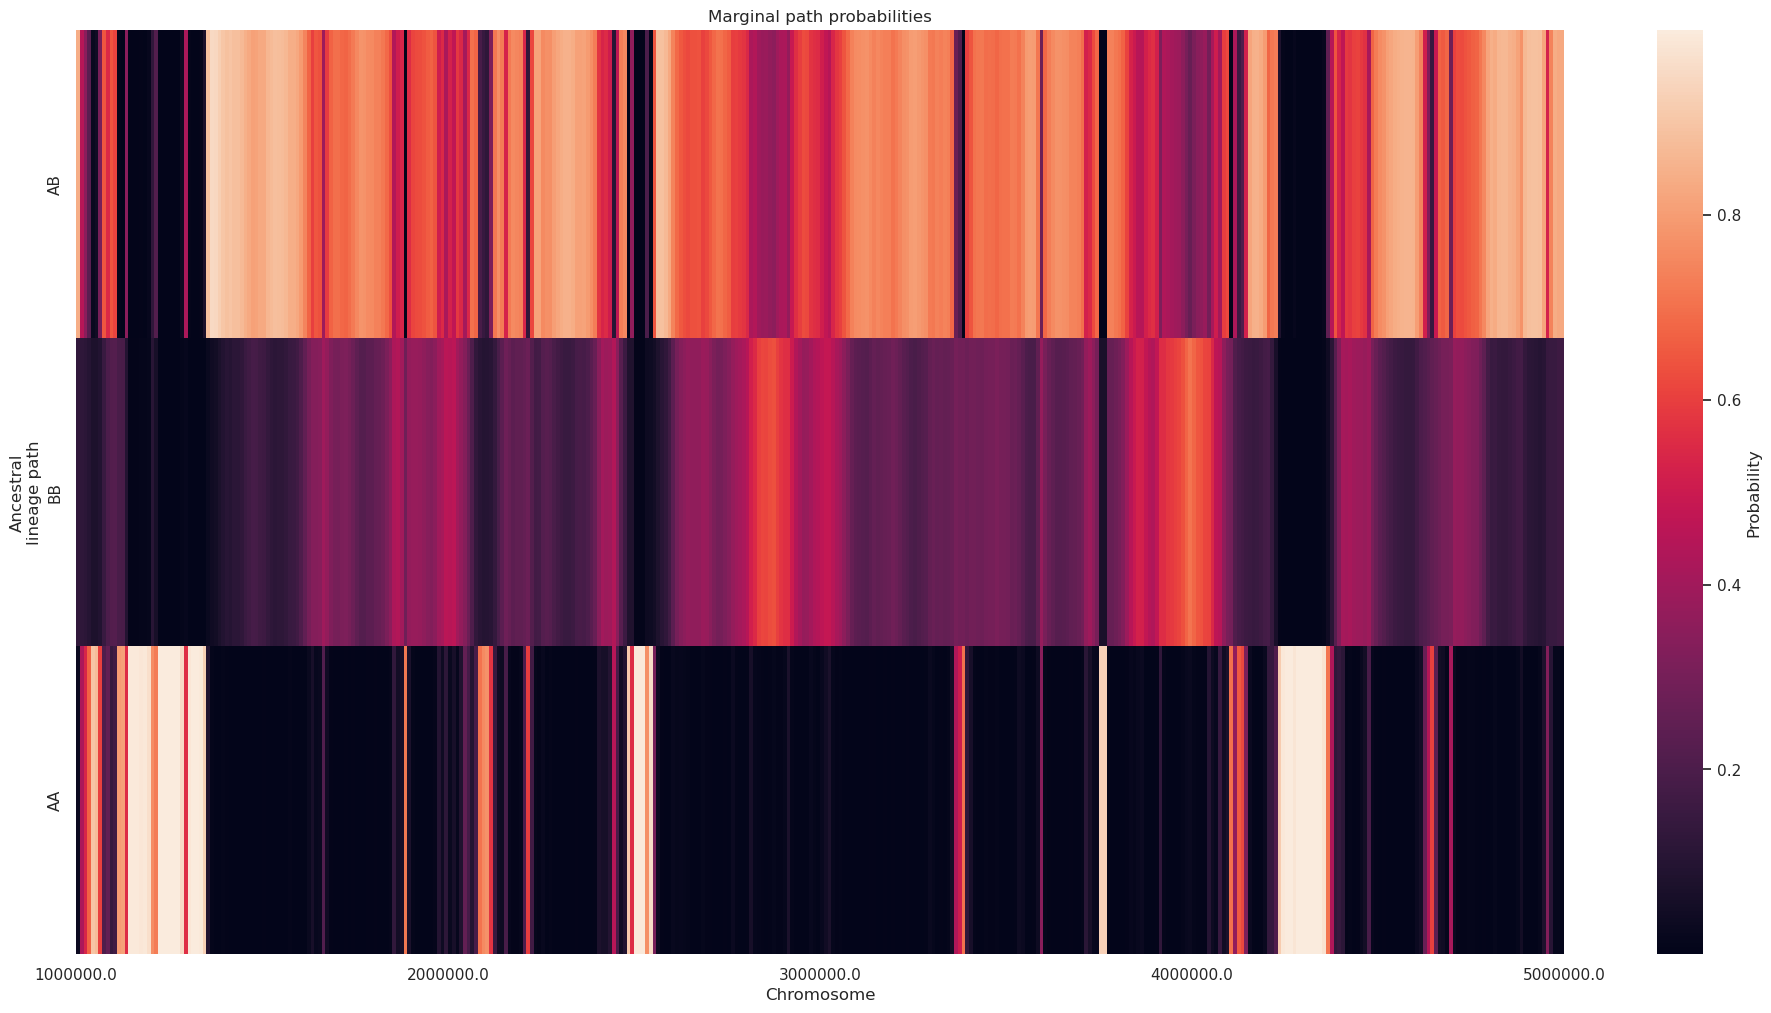

In [37]:
# No conditioning
probs = np.array([prob_AA_marginal,prob_BB_marginal,prob_AB_marginal])
ax = sns.heatmap(probs[:,start:end],cbar_kws={'label': 'Probability'})
# ax.set_yticks(ticks=ydom,labels=yticks_labs,rotation='horizontal')
ax.set_xticks(ticks=xtickslocs,labels=xtickslabs,rotation='horizontal')
ax.set_xlabel('Chromosome')
ax.set_ylabel('Ancestral\nlineage path')
plt.yticks([0.5,1.5,2.5],['AA','BB','AB'])
ax.invert_yaxis()
ax.set_title('Marginal path probabilities')
plt.show()

<Axes: ylabel='Count'>

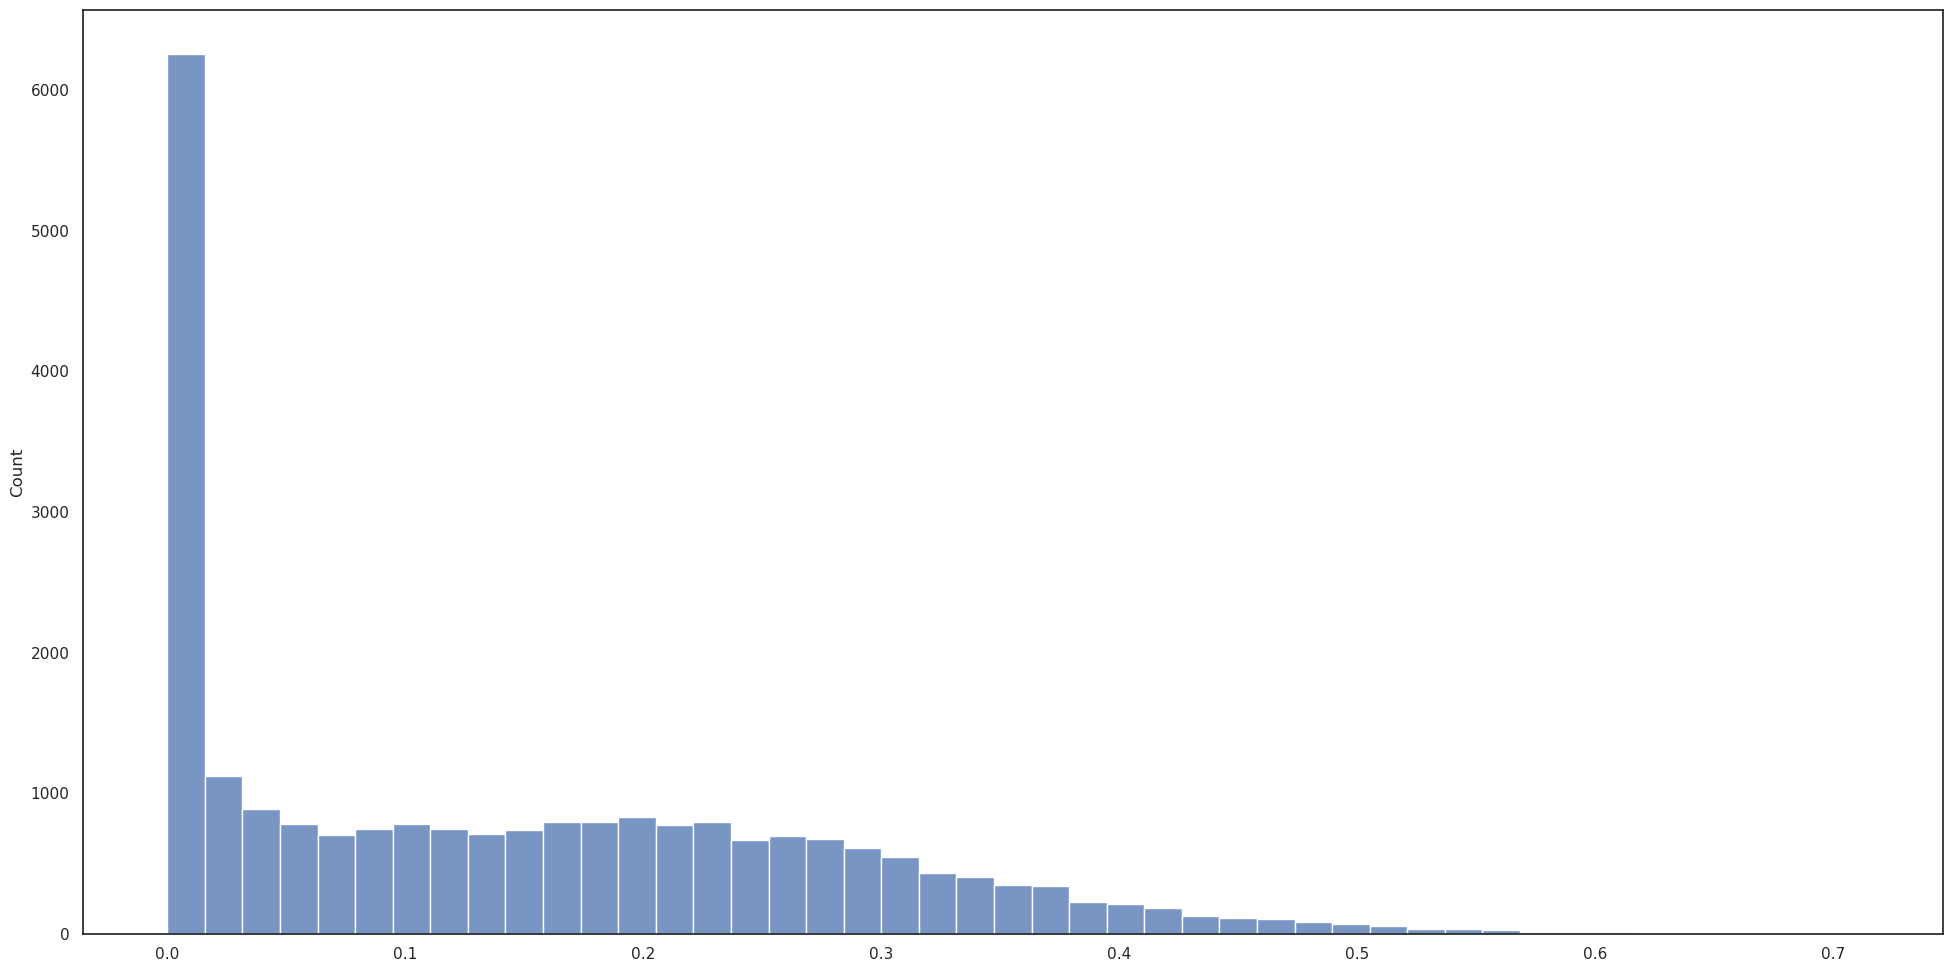

In [38]:
sns.histplot(prob_BB_marginal)

In [39]:
BB_df = pd.DataFrame({"window_start": list(range(0, len(prob_BB_marginal)*step_size, step_size)),
                      "prob_BB": prob_BB_marginal})
BB_df

,window_start,prob_BB
0,0,0.209610
1,10000,0.222454
2,20000,0.223258
3,30000,0.229222
4,40000,0.203216
...,...,...
23505,235050000,0.000316
23506,235060000,0.000378
23507,235070000,0.000533
23508,235080000,0.008066


In [ ]:
sns.scatterplot(data=BB_df.iloc[:100000], x="window_start", y="prob_BB")

<Axes: xlabel='window_start', ylabel='prob_BB'>

"Worse" example.

In [41]:
D = 50 # number of discrete time intervals in the HMM
T_1 = 22 # composite ML estimate of admixture time
T_2 = 34 # composite ML estimate of divergence time
T_2_flat = T_1+(T_2-T_1)*2 # index of T_2 in flatten HMM transition matrix
D_flat = T_1 + (T_2-T_1)*2 + (D-T_2)*3 # number of indices in posterior decoding; there are 32 time intervals and T_1 and T_2 are 13 and 21 respectively. Before T_1 only c=AA is possible; between T_1 and T_2 c=AA or C=BB is possible; after T_2 c=AA, c=BB and c=AB are possible
all_A = get_all_A_indices(D_flat,T_1,T_2) # indices of c=AA
all_B = get_all_B_indices(D_flat,T_1,T_2) # indices of c=BB ( implicitly, t>T_1 for c=BB to have non zero probability)
all_AB = get_AB_poststruct_indices(D_flat,T_1,T_2) # indices of c=AB
all_A_given_t_bigger_ts = [i for i in all_A if i>=T_1] # indices of c=AA and t>T_1
all_A_given_t_bigger_te = [i for i in all_A if i>=T_2_flat] # indices of c=AA and t>T_2
all_B_given_t_bigger_te = [i for i in all_B if i>=T_2_flat] # indices of c=B and t>T_2
all_AB_given_t_bigger_te = [i for i in all_AB if i>=T_2_flat] # indices of c=AB and t>T_2
all_A_given_t_bigger_ts_smaller_te = [i for i in all_A if i>=T_1 and i<T_2_flat] # indices of c=AA and T_1<t<T_2
all_B_given_t_bigger_ts_smaller_te = [i for i in all_B if i>=T_1 and i<T_2_flat] # indices of c=BB and T_1<t<T_2
t_in_structured_period = [i for i in range(T_1,T_2_flat)] # index of t for structured period
step_size=400*25 # length between base pairs of posterior decoding

In [42]:

decode_file = "../steps/cobraa/PD_0010/aut_NC_071443.1_decode.txt"# change to path of decoding file
decode = np.loadtxt(decode_file) # load file
decode_position = decode[0,:] # get the genomic position
posterior = decode[1:,:] # get the full posterior, this must sum to 1

prob_AA_marginal = posterior[all_A,:].sum(axis=0) # P(c=AA|X)
prob_BB_marginal = posterior[all_B,:].sum(axis=0) # P(c=BB|X)
prob_AB_marginal = posterior[all_AB,:].sum(axis=0) # # P(c=AB|X)

In [43]:
posterior[all_A,:].shape

(50, 20280)

In [44]:
posterior[all_B,:].shape

(28, 20280)

In [45]:
posterior[all_AB,:].shape

(16, 20280)

In [46]:
np.concatenate([posterior[all_A,:], posterior[all_B,:], posterior[all_AB,:]])

array([[6.09285264e-04, 1.01728406e-05, 1.81554792e-04, ...,
        3.83001243e-06, 7.03865965e-08, 2.41918246e-12],
       [6.92079170e-04, 2.48022286e-05, 4.32225908e-04, ...,
        9.35117449e-06, 1.73607440e-07, 5.98810462e-12],
       [7.90305085e-04, 3.25012289e-05, 5.62401140e-04, ...,
        1.22602343e-05, 2.28264519e-07, 7.88144493e-12],
       ...,
       [5.93569168e-03, 5.12157858e-03, 9.80522599e-03, ...,
        8.09192149e-03, 5.23848423e-02, 1.67610083e-02],
       [5.78575720e-03, 4.75993727e-03, 9.76061475e-03, ...,
        7.88208159e-03, 6.13762050e-02, 5.38228107e-02],
       [2.73776632e-02, 2.07867966e-02, 4.49246849e-02, ...,
        3.72882995e-02, 3.61426968e-01, 8.35849984e-01]])

In [ ]:
start = 300
end = 1000
num_xticks = 5
xtickslocs = np.linspace(start,end,num_xticks) - start
xtickslabs = [i for i in np.linspace(start,end,num_xticks)*step_size]

plt.rcParams['figure.figsize'] = [24, 12] 
plt.rcParams.update({'font.size': 25})

np.linspace(start,end,num_xticks)*step_size

# full posterior (coalescence times and lineage paths)
ax = sns.heatmap(posterior[:,start:end],cbar_kws={'label': 'Probability'})
# ax.set_yticks(ticks=ydom,labels=yticks_labs,rotation='horizontal')
ax.set_xticks(ticks=xtickslocs,labels=xtickslabs,rotation='horizontal')
ax.set_xlabel('Chromosome')
ax.set_ylabel('Coalescence times and ancestral lineage path')
ax.invert_yaxis()
ax.set_title('Full posterior')

plt.show()

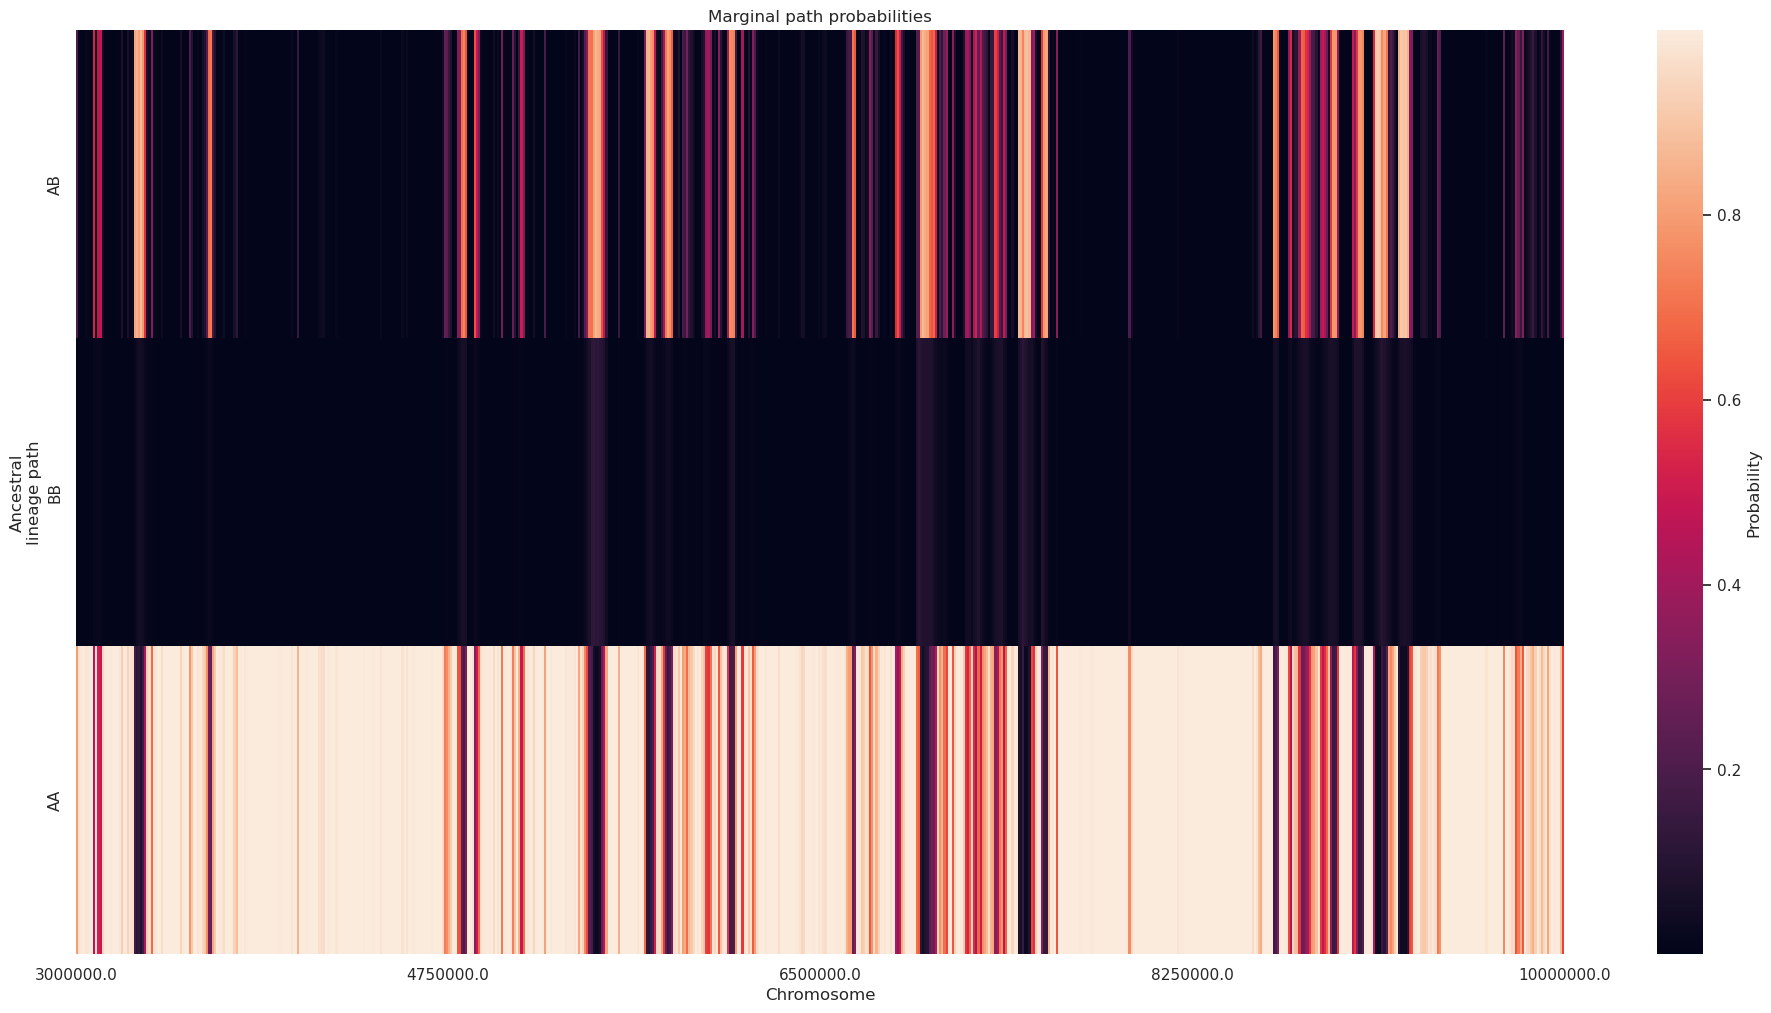

In [48]:
# No conditioning
probs = np.array([prob_AA_marginal,prob_BB_marginal,prob_AB_marginal])
ax = sns.heatmap(probs[:,start:end],cbar_kws={'label': 'Probability'})
# ax.set_yticks(ticks=ydom,labels=yticks_labs,rotation='horizontal')
ax.set_xticks(ticks=xtickslocs,labels=xtickslabs,rotation='horizontal')
ax.set_xlabel('Chromosome')
ax.set_ylabel('Ancestral\nlineage path')
plt.yticks([0.5,1.5,2.5],['AA','BB','AB'])
ax.invert_yaxis()
ax.set_title('Marginal path probabilities')
plt.show()

Full plot, showing all parts of these plots in an easily reproducible manner.
Load the unstructured and best structured models per ind, plot them (including splittimes).
Plot a picked region with highest BB, plot it.
Plot a larger area with the marginal path probs.
Also report the variables of interest.